# Analyzing the MSTIS simulation

Included in this notebook:

* Opening files for analysis
* Rates, fluxes, total crossing probabilities, and condition transition probabilities
* Per-ensemble properties such as path length distributions and interface crossing probabilities
* Move scheme analysis
* Replica exchange analysis
* Replica move history tree visualization
* Replaying the simulation
* MORE TO COME! Like free energy projections, path density plots, and more

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

The optimum way to use storage depends on whether you're doing production or analysis. For analysis, you should open the file as an `AnalysisStorage` object. This makes the analysis much faster.

In [2]:
%%time
storage = paths.AnalysisStorage("ala_mstis_production.nc")

CPU times: user 22.1 s, sys: 1.55 s, total: 23.6 s
Wall time: 23.8 s


In [3]:
print "PathMovers:", len(storage.pathmovers)
print "Engines:", len(storage.engines)
print "Samples:", len(storage.samples)
print "Ensembles:", len(storage.ensembles)
print "SampleSets:", len(storage.samplesets)
print "Snapshots:", len(storage.snapshots)
print "Trajectories:", len(storage.trajectories)
print "Networks:", len(storage.networks)

PathMovers: 125
Engines: 3
Samples: 2654
Ensembles: 227
SampleSets: 2001
Snapshots: 103078
Trajectories: 1612
Networks: 1


In [4]:
%%time
mstis = storage.networks[0]

CPU times: user 14 µs, sys: 1 µs, total: 15 µs
Wall time: 18.1 µs


In [5]:
%%time
for cv in storage.cvs:
    print cv.name, cv._store_dict

opB None
phi <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x114c07390>
psi <openpathsampling.netcdfplus.chaindict.StoredDict object at 0x11a62d710>
opA None
opC None
opD None
opF None
opE None
CPU times: user 2.2 ms, sys: 1.73 ms, total: 3.94 ms
Wall time: 2.45 ms


## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [6]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 2, 'bin_range' : (0.0, 90) }
mstis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 100) }

In [7]:
%%time
mstis.rate_matrix(storage.steps, force=True)

/Users/bolhuis/git/openpathsampling/openpathsampling/numerics/wham.py:336: RuntimeWarning: invalid value encountered in divide
  addends_k = np.divide(numerator_byQ, sum_over_Z_byQ)
/Users/bolhuis/git/openpathsampling/openpathsampling/numerics/wham.py:409: RuntimeWarning: invalid value encountered in double_scalars
  output[val] = sum_k_Hk_Q[val] / sum_w_over_Z


CPU times: user 5.23 s, sys: 38.8 ms, total: 5.26 s
Wall time: 5.25 s


,A,B,C,D
A,NaN,0.0554563717468 /ps,0.00638917535938 /ps,0.0 /ps
B,0.163505141577 /ps,NaN,0.00597118669563 /ps,0.0 /ps
C,0.0367656046865 /ps,0.0245104031244 /ps,NaN,0.0263958187493 /ps
D,0.0 /ps,0.0 /ps,0.201130041241 /ps,NaN


The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [8]:
stateA = storage.volumes["A"]
stateB = storage.volumes["B"]
stateC = storage.volumes["C"]

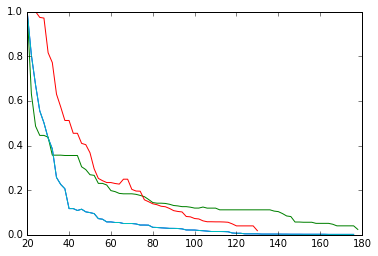

In [9]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB)
plt.plot(tcp_CA.x, tcp_CA)
plt.plot(tcp_BC.x, tcp_BC)
plt.plot(tcp_AC.x, tcp_AC) # same as tcp_AB in MSTIS

We normally look at these on a log scale:

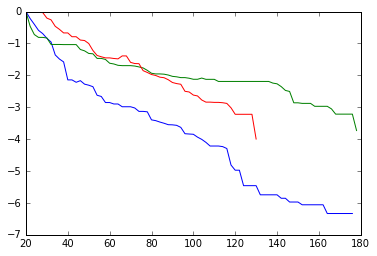

In [10]:
plt.plot(tcp_AB.x, np.log(tcp_AB))
plt.plot(tcp_CA.x, np.log(tcp_CA))
plt.plot(tcp_BC.x, np.log(tcp_BC))

### Flux

Here we also calculate the flux contribution to each transition. The flux is calculated based on 

In [11]:
import pandas as pd
flux_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    flux_matrix.set_value(state_pair[0], state_pair[1], transition._flux)

flux_matrix

,"{x|opA(x) in [0.0, 10.0]}","{x|opB(x) in [0.0, 10.0]}","{x|opC(x) in [0.0, 10.0]}","{x|opD(x) in [0.0, 10.0]}"
"{x|opA(x) in [0.0, 10.0]}",NaN,2.49221183801 /ps,2.49221183801 /ps,2.49221183801 /ps
"{x|opB(x) in [0.0, 10.0]}",0.9977827051 /ps,NaN,0.9977827051 /ps,0.9977827051 /ps
"{x|opC(x) in [0.0, 10.0]}",0.529100529101 /ps,0.529100529101 /ps,NaN,0.529100529101 /ps
"{x|opD(x) in [0.0, 10.0]}",1.80055401662 /ps,1.80055401662 /ps,1.80055401662 /ps,NaN


### Conditional transition probability

In [12]:
outer_ctp_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.set_value(state_pair[0], state_pair[1], transition.ctp[transition.ensembles[-1]])    

outer_ctp_matrix

,"{x|opA(x) in [0.0, 10.0]}","{x|opB(x) in [0.0, 10.0]}","{x|opC(x) in [0.0, 10.0]}","{x|opD(x) in [0.0, 10.0]}"
"{x|opA(x) in [0.0, 10.0]}",NaN,0.663668,0.0764618,0
"{x|opB(x) in [0.0, 10.0]}",0.930535,NaN,0.033983,0
"{x|opC(x) in [0.0, 10.0]}",0.350825,0.233883,NaN,0.251874
"{x|opD(x) in [0.0, 10.0]}",0,0,0.321339,NaN


In [13]:
ctp_by_interface = pd.DataFrame(index=mstis.transitions)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    for ensemble_i in range(len(transition.ensembles)):
        ctp_by_interface.set_value(
            state_pair, ensemble_i,
            transition.conditional_transition_probability(
                storage.steps,
                transition.ensembles[ensemble_i]
        ))
    
    
ctp_by_interface  

,0,1,2,3
"({x|opA(x) in [0.0, 10.0]}, {x|opB(x) in [0.0, 10.0]})",0.000000,0.165917,0.658171,0.663668
"({x|opD(x) in [0.0, 10.0]}, {x|opC(x) in [0.0, 10.0]})",0.189405,0.129435,0.321339,NaN
"({x|opD(x) in [0.0, 10.0]}, {x|opB(x) in [0.0, 10.0]})",0.000000,0.000000,0.000000,NaN
"({x|opB(x) in [0.0, 10.0]}, {x|opC(x) in [0.0, 10.0]})",0.000000,0.000000,0.000000,0.033983
"({x|opC(x) in [0.0, 10.0]}, {x|opA(x) in [0.0, 10.0]})",0.005997,0.281859,0.350825,NaN
"({x|opA(x) in [0.0, 10.0]}, {x|opD(x) in [0.0, 10.0]})",0.000000,0.000000,0.000000,0.000000
"({x|opC(x) in [0.0, 10.0]}, {x|opB(x) in [0.0, 10.0]})",0.040480,0.119940,0.233883,NaN
"({x|opB(x) in [0.0, 10.0]}, {x|opA(x) in [0.0, 10.0]})",0.135932,0.250375,0.425287,0.930535
"({x|opC(x) in [0.0, 10.0]}, {x|opD(x) in [0.0, 10.0]})",0.018491,0.155422,0.251874,NaN
"({x|opA(x) in [0.0, 10.0]}, {x|opC(x) in [0.0, 10.0]})",0.000000,0.000000,0.056972,0.076462


## Path ensemble properties

In [14]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of 

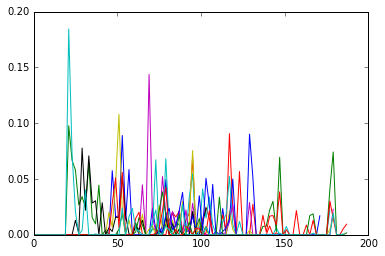

In [15]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [16]:
# add visualization of the sum

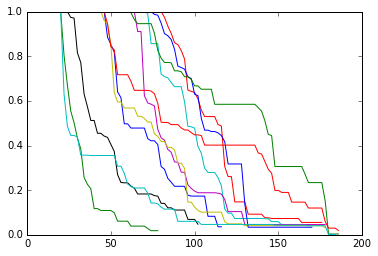

In [17]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative)

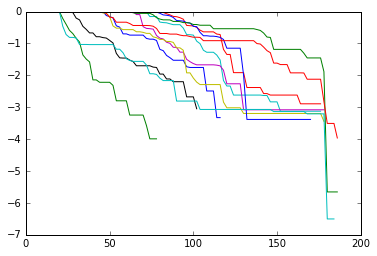

In [18]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

### Path length histograms

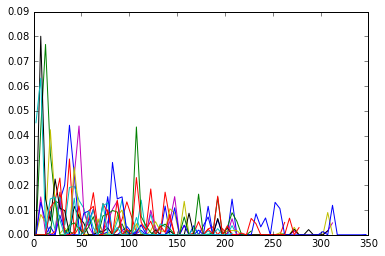

In [19]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

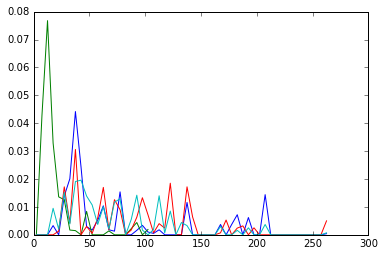

In [20]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [21]:
scheme = storage.schemes[0]

In [22]:
scheme.move_summary(storage.steps)

pathreversal ran 25.100% (expected 24.75%) of the cycles with acceptance 304/502 (60.56%)
ms_outer_shooting ran 2.650% (expected 3.30%) of the cycles with acceptance 35/53 (66.04%)
shooting ran 46.200% (expected 46.20%) of the cycles with acceptance 665/924 (71.97%)
minus ran 3.050% (expected 2.64%) of the cycles with acceptance 52/61 (85.25%)
repex ran 23.000% (expected 23.10%) of the cycles with acceptance 189/460 (41.09%)


In [23]:
scheme.move_summary(storage.steps, 'shooting')

OneWayShootingMover Out B 2 ran 3.400% (expected 3.30%) of the cycles with acceptance 44/68 (64.71%)
OneWayShootingMover Out D 2 ran 3.550% (expected 3.30%) of the cycles with acceptance 43/71 (60.56%)
OneWayShootingMover Out A 1 ran 3.100% (expected 3.30%) of the cycles with acceptance 45/62 (72.58%)
OneWayShootingMover Out B 3 ran 3.350% (expected 3.30%) of the cycles with acceptance 45/67 (67.16%)
OneWayShootingMover Out A 2 ran 2.900% (expected 3.30%) of the cycles with acceptance 38/58 (65.52%)
OneWayShootingMover Out C 0 ran 3.650% (expected 3.30%) of the cycles with acceptance 66/73 (90.41%)
OneWayShootingMover Out A 3 ran 3.000% (expected 3.30%) of the cycles with acceptance 30/60 (50.00%)
OneWayShootingMover Out C 1 ran 3.650% (expected 3.30%) of the cycles with acceptance 52/73 (71.23%)
OneWayShootingMover Out B 0 ran 3.400% (expected 3.30%) of the cycles with acceptance 57/68 (83.82%)
OneWayShootingMover Out D 0 ran 3.400% (expected 3.30%) of the cycles with acceptance 51/68

In [24]:
scheme.move_summary(storage.steps, 'minus')

Minus ran 0.650% (expected 0.66%) of the cycles with acceptance 9/13 (69.23%)
Minus ran 0.750% (expected 0.66%) of the cycles with acceptance 14/15 (93.33%)
Minus ran 0.850% (expected 0.66%) of the cycles with acceptance 13/17 (76.47%)
Minus ran 0.800% (expected 0.66%) of the cycles with acceptance 16/16 (100.00%)


In [25]:
scheme.move_summary(storage.steps, 'repex')

ReplicaExchange ran 1.850% (expected 1.65%) of the cycles with acceptance 10/37 (27.03%)
ReplicaExchange ran 1.300% (expected 1.65%) of the cycles with acceptance 20/26 (76.92%)
ReplicaExchange ran 1.450% (expected 1.65%) of the cycles with acceptance 13/29 (44.83%)
ReplicaExchange ran 1.700% (expected 1.65%) of the cycles with acceptance 2/34 (5.88%)
ReplicaExchange ran 1.600% (expected 1.65%) of the cycles with acceptance 10/32 (31.25%)
ReplicaExchange ran 1.700% (expected 1.65%) of the cycles with acceptance 26/34 (76.47%)
ReplicaExchange ran 1.550% (expected 1.65%) of the cycles with acceptance 26/31 (83.87%)
ReplicaExchange ran 2.050% (expected 1.65%) of the cycles with acceptance 30/41 (73.17%)
ReplicaExchange ran 1.400% (expected 1.65%) of the cycles with acceptance 1/28 (3.57%)
ReplicaExchange ran 1.550% (expected 1.65%) of the cycles with acceptance 19/31 (61.29%)
ReplicaExchange ran 2.200% (expected 1.65%) of the cycles with acceptance 5/44 (11.36%)
ReplicaExchange ran 1.500%

In [26]:
scheme.move_summary(storage.steps, 'pathreversal')

PathReversal ran 1.400% (expected 1.65%) of the cycles with acceptance 26/28 (92.86%)
PathReversal ran 1.750% (expected 1.65%) of the cycles with acceptance 24/35 (68.57%)
PathReversal ran 1.750% (expected 1.65%) of the cycles with acceptance 24/35 (68.57%)
PathReversal ran 1.500% (expected 1.65%) of the cycles with acceptance 0/30 (0.00%)
PathReversal ran 1.450% (expected 1.65%) of the cycles with acceptance 28/29 (96.55%)
PathReversal ran 1.750% (expected 1.65%) of the cycles with acceptance 15/35 (42.86%)
PathReversal ran 1.650% (expected 1.65%) of the cycles with acceptance 4/33 (12.12%)
PathReversal ran 2.250% (expected 1.65%) of the cycles with acceptance 45/45 (100.00%)
PathReversal ran 2.150% (expected 1.65%) of the cycles with acceptance 37/43 (86.05%)
PathReversal ran 1.600% (expected 1.65%) of the cycles with acceptance 24/32 (75.00%)
PathReversal ran 2.200% (expected 1.65%) of the cycles with acceptance 13/44 (29.55%)
PathReversal ran 1.700% (expected 1.65%) of the cycles w

### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [27]:
repx_net = paths.ReplicaNetwork(scheme, storage.steps)

#### Replica exchange mixing matrix

In [28]:
repx_net.mixing_matrix()

,18,17,0,4,1,5,2,6,3,14,13,12,11,10,15,16,7,8,9
18,0.000000,0.000000,0.017274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
17,0.000000,0.000000,0.000000,0.026871,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
0,0.017274,0.000000,0.000000,0.000000,0.024952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.026871,0.000000,0.000000,0.000000,0.019194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.024952,0.000000,0.000000,0.000000,0.036468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.019194,0.000000,0.000000,0.000000,0.049904,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.036468,0.000000,0.000000,0.000000,0.030710,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.049904,0.000000,0.000000,0.000000,0.003839,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030710,0.000000,0.000000,0.009597,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003839,0.009597,0.000000,0.057582,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

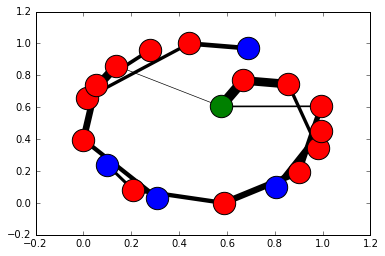

In [29]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [30]:
import openpathsampling.visualize as vis
reload(vis)
from IPython.display import SVG

In [31]:
tree = vis.PathTree(
    [step for step in storage.steps if not isinstance(step.change, paths.EmptyPathMoveChange)],
    vis.ReplicaEvolution(replica=3, accepted=False)
)
tree.options.css['width'] = 'inherit'

SVG(tree.svg())

AttributeError: 'module' object has no attribute 'EmptyPathMoveChange'

In [ ]:
decorrelated = tree.generator.decorrelated
print "We have " + str(len(decorrelated)) + " decorrelated trajectories."

### Visualizing trajectories

## Histogramming data (TODO)